# APMA2822B Homework 2 - Hammad Izhar + Robert Scheidegger

In this report we plan to analyze the performance of matrix-matrix multiplication using a variety of multiplication methods. These experiments were conducted using Brown's compute grid OSCAR using 16 cores on an **Intel Xeon Platinum 8268 CPU** and 16GB of DDR4 RAM.

A total of 378 configurations were run varying multiplication methods, size of matrices, and number of threads. A summary of configuration variables is given below:

<center>

| Multipliers                         | Description                                                                             |
| ----------------------------------- | --------------------------------------------------------------------------------------- |
| `DefaultMultiplierIJK`                | Naive matrix multiplication implementation                                              |
| `DefaultMultiplierJIK`                | Naive matrix multiplication implementation, flipping outer two loops                    |
| `DefaultMultiplierIJKC`          | Naive matrix multiplication implementation, caching result in a variable                |
| `DefaultMultiplierIJKT`       | Transposes the right matrix to improve spatial locality                                 |
| `DefaultMultiplierIJKTC` | Transposes the right matrix to improve spatial locality and caches result in a variable |
| `Collapse2Multiplier`                 | Uses OpenMP `collapse(2)`                                                                                        |
| `Collapse3Multiplier`                 | Uses OpenMP `collapse(3)`                                                                                        |
| `BlockingMultiplier`                  | Uses loop blocking                                                                                        |

Matrices of size $n$-by-$m$ and $m$-by-$k$ were multiplied where $n, m, k \in \{10, 100, 1000\}$. The handout for this assignment says to use sizes also of order $O(10^4)$, but since naive matrix multiplication is of order $O(n^3)$, this results in incredibly slow benchmarks, so we omitted them for this reason.

The number of threads `n_threads` varied in the set $\{4, 16\}$.

Loop block sizes varied in the set $\{16, 32, 64, 128, 256\}$. We varied the various block sizes using the `--blocking` flag in the main benchmark file, but this didn't seem to really affect the performance at all, so it is not included in the general results. Specifically, we tried using various blocking sizes for each possible iteration loop, and did a grid search on all of them, but couldn't find any relevant performance improvement (at best, the blocking seemed to achieve the same results as the other implementations).

</center>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../data/data.csv', encoding='latin-1')
df['flops'] = 2 * df['n'] * df['n'] / df['time_us'] * 1e6
df['gflops'] = df['flops'] / 1e9
df['iops'] = 5 * df['n'] * df['m'] / df['time_us'] * 1e6

## Roofline Analysis

For the purposes of this analysis, we will look at the results from the $n = 1000, k = 1000, m = 1000$ runs, and we will choose to look at the `DefaultMultiplierIJKCached` values, since this exhibits a simple algorithm that is still reasonably performant, and thus quite good for Roofline analysis. 

Excluding timing and parallelization primitives, the code of `DefaultMultiplierIJKCached` is as follows:

```c++
// include/multipliers/default_multipliers.hpp

#pragma omp parallel for num_threads(n_threads)
for (uint32_t i = 0; i < N; i++) {
    for (uint32_t j = 0; j < M; j++) {
        float cij = C[i][j];
        for (uint32_t k = 0; k < K; k++) {
            cij = cij + A[i][k] * B[k][j];
        }
        C[i][j] = cij;
    }
}
```

To compute the arithmetic intensity, we first count the number of I/O operations (memory accesses) required. For this, it should suffice to count the operations within the inner-most loop, because these dominate the other factors for sufficiently large $k$ (which is $k = 1000$ in this case, making the other loads negligible):

1. Load `A[i]`                                                   a pointer to the column, 8 bytes
2. Load `A[i][j]`                                                a float, 4 bytes
3. Load `B[k]`                                                   a pointer to the column, 8 bytes
4. Load `B[k][j]`                                                a float, 4 bytes
5. Load `cij`                                                    a float, 4 bytes
6. Store temporary variable for multiplication                   a float, 4 bytes
6. Store `cij`                                                   a float, 4 bytes

This is a total of 5 I/O operations totalling $36$ bytes transferred. We then count the number of floating point operations:

1. Multiply `RESULT = A[i][k] * B[k][j]`
2. Add `RESULT + cij`

Therefore, the total arithmetic intensity is given by:

$$
    \text{Arithmetic Intensity} = \frac{2 \ \text{FLOPS}}{36 \ \text{Accesses}} = \frac{1}{18} \ \frac{\text{FLOPS}}{\text{byte}}
$$

From the [Ark Spec](https://ark.intel.com/content/www/us/en/ark/products/192481/intel-xeon-platinum-8268-processor-35-75m-cache-2-90-ghz.html) for the Xeon Platinum 8268 the max turbo frequency is $3.90 \ \text{GHz}$. According to this [community post](https://community.intel.com/t5/Software-Tuning-Performance/Calculate-the-Max-Flops-on-Skylake/m-p/1160952) Intel Skylake-X processors (the 8268 implements the Cascade Lake architecture) can perform 24 floating point operations per clock cycle per core. Therefore using 32 cores, we can achieve a maximum FLOP rate of


$$
    \text{Maximum FLOP Rate} = 32 \ \text{cores} \cdot \frac{2.90 \cdot 10^9 \ \text{cycle}}{1 \ \text{second}} \cdot \frac{24 \ \text{FLOPS}}{1 \ \text{cycle-core}} = 2.227 \ \text{TFLOPS}
$$

The Xenon Platinum 8268 supports DDR4 RAM with maximum speeds of $2933 \ \text{MHz}$ and 6 memory channels. Therefore, the maximum memory bandwidth of the processor is given by:
$$
    \text{Maximum Memory Bandwidth} = 8 \ \text{bytes} \cdot \frac{2.933 \ \text{GHz}}{1 \ \text{channel}} \cdot 6 \ \text{channel} = 140.78 \ \text{GHz} = 140.78 \ \text{GB/s}
$$

The ridge point of our roofline plot is therefore given by:

$$
    I^* = \frac{\text{Maximum FLOP Rate}}{\text{Maximum Memory Bandwidth}} = \frac{2.227 \ \text{TFLOPS}}{140.78 \ \text{GB/s}} = 15.81 \ \frac{\text{FLOPs}}{\text{byte}}
$$

The predicted FLOP rate is given by:
$$
    \text{Predicted FLOP Rate} = \frac{1 \ \text{FLOPS}}{18 \ \text{byte}} \cdot \frac{140.78 \cdot 10^9 \ \text{bytes}}{1 \ \text{second}} = 77.82 \ \text{GFLOPs}
$$

Therefore, we are in bandwidth-limited region of the roof-line plot. This is within the margin of error of the experimental results we determined.

,i,n,m,k,num_threads,multiplier,iterations,time_us,stddev_us,flops,gflops,iops
365,366,1000,1000,1000,4,DefaultMultiplierIJKCached,4,1215753.25,25796.367188,1.645071e+06,0.001645,4.112677e+06
372,373,1000,1000,1000,16,DefaultMultiplierIJKCached,4,1110845.00,30518.808594,1.800431e+06,0.001800,4.501078e+06


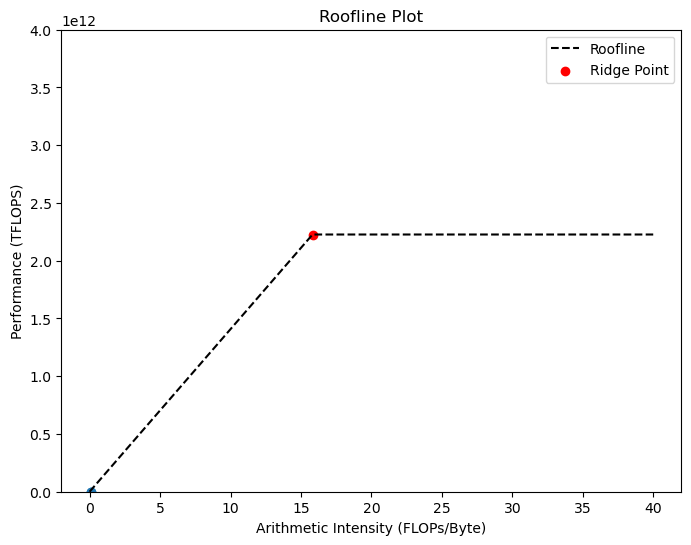

In [5]:
# Compute the roof-line plot for the analysis above.
subset = df[df['multiplier'] == 'DefaultMultiplierIJKCached']
subset = subset[subset['m'] == 1000]
subset = subset[subset['n'] == 1000]
subset = subset[subset['k'] == 1000]

# Plot the roof-line plot
max_flop_rate = 2.227e12 # 7.987 TFLOPS
max_mem_bandwidth = 140.78e9 # 140.78 GB/s
ridge_point = max_flop_rate / max_mem_bandwidth

arithmetic_intensity = np.arange(0, 40, 0.01);
roofline = np.minimum(arithmetic_intensity * max_mem_bandwidth, max_flop_rate)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(arithmetic_intensity, roofline, 'k--', label='Roofline')
ax.scatter(ridge_point, ridge_point * max_mem_bandwidth, marker='o', color='r', label='Ridge Point')

ax.scatter(1/14 * np.ones(len(subset)), subset["flops"])

ax.set_ylim(0, 4e12)
ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
ax.set_ylabel('Performance (TFLOPS)')
ax.set_title('Roofline Plot')
ax.legend()

subset



## Performance Analysis

To test each of the 378 possible configurations we performed an experiment on matrices of varying sizes using a batch script on Oscar. Warmup computations were used prior to the start of the experiments. Each experiment was repeated for 10 iterations and the the mean and standard deviations of each runtime was computed. A sample of the data for the largest set of matrices is shown below.

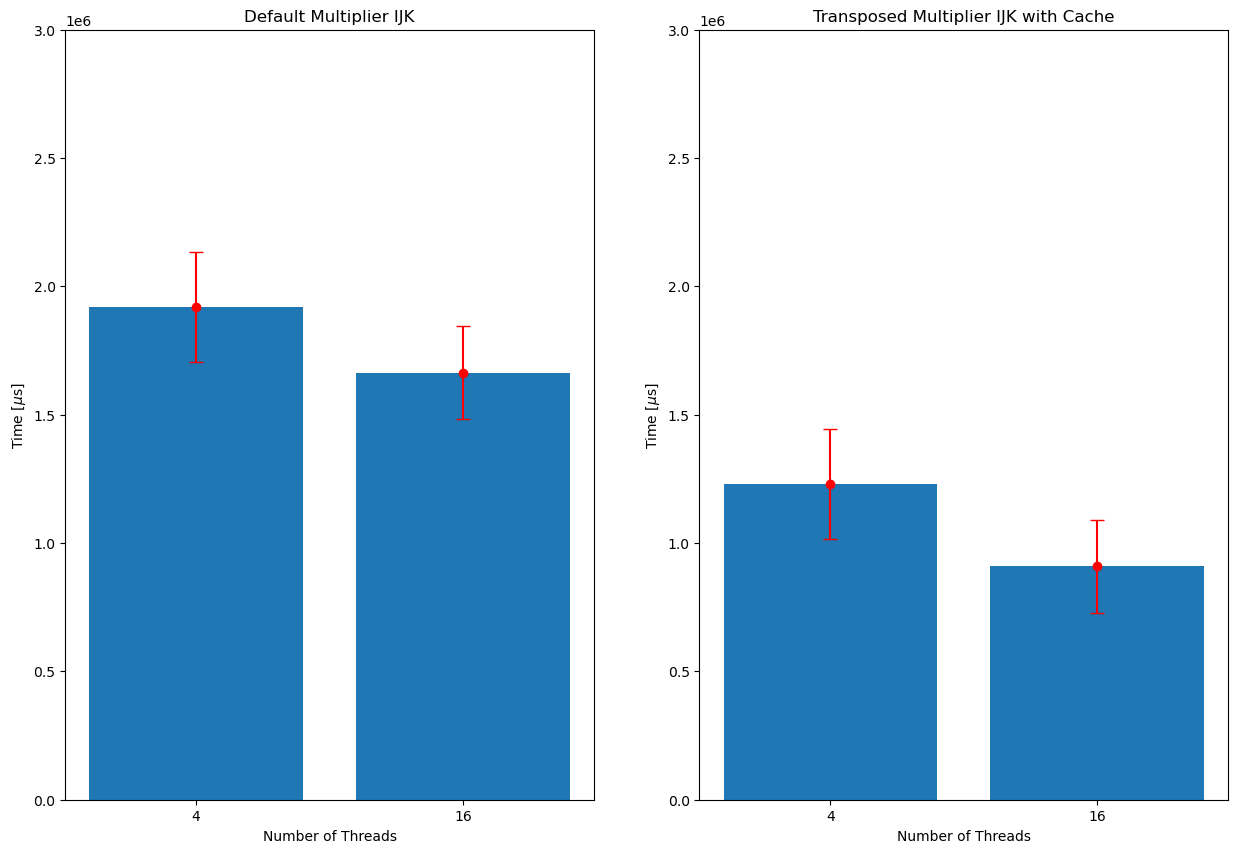

In [30]:
# allocators bar charts for large size over threads and multipliers
def get_allocator_data():
    # subset = df[df['allocator'] == name]
    subset = df
    subset = subset[subset['m'] == 1000]
    subset = subset[subset['n'] == 1000]
    subset = subset[subset['k'] == 1000]
    return subset[subset['multiplier'] == 'DefaultMultiplierIJK'].groupby("num_threads").mean(numeric_only=True), subset[subset['multiplier'] == 'DefaultMultiplierIJKTransposeCached'].groupby("num_threads").mean(numeric_only=True)

default_mult, improved_mult = get_allocator_data()

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

trace = default_mult["time_us"]
ax = axs[0]
ax.bar([str(x) for x in trace.keys()], trace.values)
ax.errorbar([str(x) for x in trace.keys()], trace.values, yerr=default_mult["stddev_us"], fmt='o', capsize=5, color="red")
ax.set_ylim(0, 3e6)
ax.set_xlabel("Number of Threads")
ax.set_ylabel("Time [$\mu$s]")
ax.set_title("Default Multiplier IJK")

trace = improved_mult["time_us"]
ax = axs[1]
ax.bar([str(x) for x in trace.keys()], trace.values)
ax.errorbar([str(x) for x in trace.keys()], trace.values, yerr=default_mult["stddev_us"], fmt='o', capsize=5, color="red")
ax.set_ylim(0, 3e6)
ax.set_xlabel("Number of Threads")
ax.set_ylabel("Time [$\mu$s]")
ax.set_title("Transposed Multiplier IJK with Cache")

plt.show()